In [ ]:
!pip install faker pyspark

In [4]:
from faker import Faker
import random
import math
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler,StringIndexer,StandardScaler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

In [5]:
spark = SparkSession.builder.getOrCreate()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df1 = pd.read_excel("KBZPay_1000 (2).xlsx",sheet_name="txn_1k_customers")
df2 = pd.read_excel("KBZPay_1000 (2).xlsx",sheet_name="1k_customer_details")

In [8]:
df1 = spark.createDataFrame(df1).drop("date_registered")
df2 = spark.createDataFrame(df2).drop("level").filter(F.col("status")!="Closed")

In [9]:
df1.count(),df2.count()

(110597, 994)

In [10]:
l1 = ["id","trn_type","new_trn_type","name","type","phone_no","vcfc","nrc","township","division","new_type","branch_id","branch","revenue_service_fee","cost_principle_commission",
"cost_residual_commission","territory","territory_upd","short_trn_type","partition_year","partition_month"]

l2 = ["phone_no","date_of_birth","customer_name","permanent_address","modifiedon","email_address","customer_nrcorpassport","date_1st_login_for_one_month",
"no_of_login_for_one_month","casa_flag","status","date_1st_login","no_of_login","date_of_birth","sub_trust_level","customer_trust_level_detail","township","stateordivision","nationality","town","primary_id_type","secondary_id_type","employment_type"]

df = df2.join(df1,df1.id==df2.customer_id).drop(*(l1+l2))

In [11]:
fake = Faker()

In [12]:
dfcid = df.select("customer_id").distinct().withColumn("new", lit(fake.random_number(digits=18)))
dftid = df.select("transaction_id").distinct().withColumn("new", lit(fake.random_number(digits=15)))

In [13]:
df = df.join(dfcid,"customer_id","inner").drop("customer_id","old").withColumnRenamed("new","customer_id")
df = df.join(dftid,"transaction_id","inner").drop("transaction_id","old").withColumnRenamed("new","transaction_id")

In [14]:
df = df.withColumn("tran_year",F.year(F.col("trn_date"))).withColumn("trn_month",F.month(F.col("trn_date"))).withColumn("trn_day",F.dayofmonth(F.col("trn_date")))
df = df.withColumn("reg_year",F.year(F.col("trn_date")))
df = df.drop("trn_date","date_registered")

In [15]:
df = df.withColumn("average_spend",F.avg(F.col("amount")).over(Window.partitionBy(["customer_id","trn_month"]))).withColumn("average_spend",F.round(F.col("average_spend")))
df = df.withColumn("transaction_count",F.count(F.col("transaction_id")).over(Window.partitionBy(["customer_id","trn_month"])))
df = df.withColumn("balance",F.lit(fake.random_element([2,1.7,3,1.2,2.2])*F.max(F.col("amount")).over(Window.partitionBy(["customer_id","trn_month"]))))

In [16]:
strList = ["gender","segment","transaction_type","reason_type","drcr_ind"]
string_indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in strList]
string_indexers_pipeline = Pipeline(stages=string_indexers)
df = string_indexers_pipeline.fit(df).transform(df).drop(*strList)

In [17]:
df.coalesce(1).write.mode("overwrite").option("header",True).csv("drive/MyDrive/cleaned/data.csv")

In [18]:
df = spark.read.option("header",True).option("inferSchema",True).csv("drive/MyDrive/cleaned/data.csv")

In [19]:
df = VectorAssembler(inputCols=df.drop("customer_id","transaction_id").columns, outputCol="vfeatures").transform(df).drop(*df.drop("customer_id","transaction_id").columns)

In [20]:
df = StandardScaler(inputCol="vfeatures", outputCol="features", withStd=True, withMean=True).fit(df).transform(df).drop("vfeatures")

In [21]:
vector_to_array_udf = udf(lambda vector: vector.toArray().tolist(), ArrayType(FloatType()))
df = df.withColumn('features', vector_to_array_udf('features'))

In [22]:
customer_array = np.array(df.select('customer_id').collect(), dtype=object)
transaction_array = np.array(df.select('transaction_id').collect(), dtype=object)
numpy_array = df.select("features").collect()

In [23]:
# train test split
l = len(numpy_array)
l70 = math.floor(0.70*l)
X_train, X_test = numpy_array[:l70],numpy_array[l70:]

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [25]:
input_layer = Input(shape=(None,14))
encoded = Dense(10, activation='relu')(input_layer)  # Encoding layer with 10 neurons
encoded = Dense(5, activation='relu')(encoded)  # Further encoding layer with 5 neurons
decoded = Dense(10, activation='relu')(encoded)  # Decoding layer with 10 neurons
output_layer = Dense(14, activation='sigmoid')(decoded)  # Output layer
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
model.fit(X_train, X_train, epochs=50, batch_size=32,validation_data=(X_test, X_test),callbacks=[early_stopping])

Epoch 1/50
2405/2405 [==============================] - 16s 6ms/step - loss: 0.8696 - val_loss: 0.6917
Epoch 2/50
2405/2405 [==============================] - 6s 3ms/step - loss: 0.7872 - val_loss: 0.6275
Epoch 3/50
2405/2405 [==============================] - 9s 4ms/step - loss: 0.7686 - val_loss: 0.6160
Epoch 4/50
2405/2405 [==============================] - 8s 3ms/step - loss: 0.7623 - val_loss: 0.5986
Epoch 5/50
2405/2405 [==============================] - 10s 4ms/step - loss: 0.7597 - val_loss: 0.5887
Epoch 6/50
2405/2405 [==============================] - 6s 3ms/step - loss: 0.7487 - val_loss: 0.5712
Epoch 7/50
2405/2405 [==============================] - 10s 4ms/step - loss: 0.7348 - val_loss: 0.5660
Epoch 8/50
2405/2405 [==============================] - 7s 3ms/step - loss: 0.7336 - val_loss: 0.5635
Epoch 9/50
2405/2405 [==============================] - 8s 3ms/step - loss: 0.7326 - val_loss: 0.5633
Epoch 10/50
2405/2405 [==============================] - 9s 4ms/step - loss: 0.

In [27]:
reconstructed_sequences = model.predict(X_test)
mse = np.mean(np.power(X_test - reconstructed_sequences, 2), axis=(1,2))
threshold = np.percentile(mse, 98)

1031/1031 [==============================] - 3s 2ms/step


In [28]:
squared_mse = np.square(mse)
mean_squared_error = np.mean(squared_mse)
rmse = np.sqrt(mean_squared_error)

In [29]:
squared_mse,mean_squared_error,rmse

(array([0.02949268, 2.45108936, 0.07682502, ..., 0.30897076, 0.51489729,
        0.21161477]),
 0.831210936850945,
 0.911707703625973)

In [30]:
anomalies = mse > threshold

In [31]:
np.count_nonzero(~anomalies),np.count_nonzero(anomalies)

(32318, 660)

In [32]:
ca70 = customer_array[l70:]
ta70 = transaction_array[l70:]

In [33]:
detected = ca70[anomalies]
detectedt = ta70[anomalies]
riskScore = mse[anomalies].astype(int).tolist()

In [34]:
ctmap = list(zip([i[0] for i in detected.tolist()],[i[0] for i in detectedt.tolist()],riskScore))
ctverify = spark.createDataFrame(ctmap,["customer_id","transaction_id","riskScore"])
percentiles = ctverify.approxQuantile("riskScore", [0.2, 0.4, 0.6, 0.8], 0.01)
conditions = [
    F.col("riskScore") >= percentiles[3],  # very high
    F.col("riskScore") >= percentiles[2],  # high
    F.col("riskScore") >= percentiles[1],  # medium
    F.col("riskScore") >= percentiles[0],  # low
    F.col("riskScore") < percentiles[0]    # very low
]
categories = ["VeryHigh", "High", "Medium", "Low", "VeryLow"]
ctverify = ctverify.withColumn("riskCategory", when(conditions[0], categories[0])
                     .when(conditions[1], categories[1])
                     .when(conditions[2], categories[2])
                     .when(conditions[3], categories[3])
                     .otherwise(categories[4]))

In [35]:
ctv = df.join(ctverify,["customer_id","transaction_id"],"left").na.fill("NoRisk","riskCategory").drop("features")

In [36]:
ctv.coalesce(1).write.mode("overwrite").option("header",True).csv("drive/MyDrive/cleaned/output.csv")

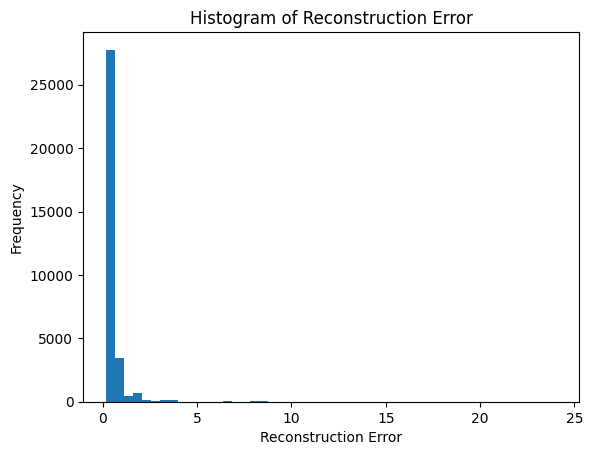

In [37]:
plt.hist(mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Error')
plt.show()

In [38]:
from sklearn.decomposition import TruncatedSVD
from mpl_toolkits.mplot3d import Axes3D

In [39]:
X_train = [i.features for i in X_train]
X_test = [i.features for i in X_test]

In [40]:
svd = TruncatedSVD(n_components=3)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

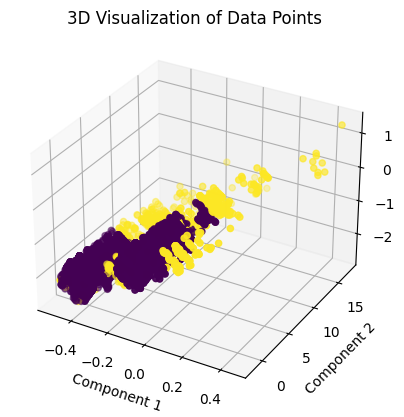

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test_svd[:, 0], X_test_svd[:, 1], X_test_svd[:, 2], c=anomalies)
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D Visualization of Data Points')
plt.show()

In [42]:
svd = TruncatedSVD(n_components=2)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

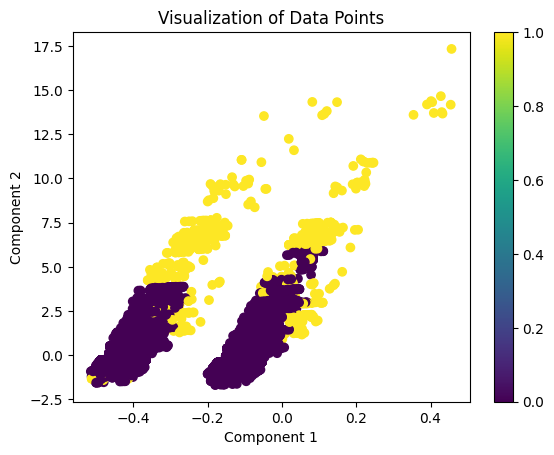

In [43]:
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=anomalies)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Visualization of Data Points')
plt.colorbar()
plt.show()